In [1]:
import numpy as np 
import json
import matplotlib.pyplot as plt
from matplotlib.cm import viridis, seismic, coolwarm, Spectral
import os
base_path = '/mnt/beegfs/home/CPHT/antoine.misery/workdir_link/qchem_comp_data/'
# base_path = '/mnt/beegfs/home/CPHT/antoine.misery/workdir_link/qchem_comp_4/166630_0/L30/NNBF/256'

In [11]:
# import re
# parent_folder = '/mnt/beegfs/home/CPHT/antoine.misery/workdir_link/qchem_comp_data/'
# # Regex to match folder names like MC_3_[0.1]
# pattern = re.compile(r'^(MC_\d+)_\[(.+)\]$')

# for folder_name in os.listdir(parent_folder):
#     match = pattern.match(folder_name)
#     if match:
#         base, f_str = match.groups()
#         new_name = f"{base}_{f_str}"
#         old_path = os.path.join(parent_folder, folder_name)
#         new_path = os.path.join(parent_folder, new_name)
#         print(f"Renaming: {folder_name} → {new_name}")
#         os.rename(old_path, new_path)

Renaming: MC_13_[0.9] → MC_13_0.9
Renaming: MC_12_[2.] → MC_12_2.
Renaming: MC_12_[0.9] → MC_12_0.9
Renaming: MC_9_[0.9] → MC_9_0.9
Renaming: MC_13_[2.] → MC_13_2.
Renaming: MC_11_[2.] → MC_11_2.
Renaming: MC_11_[0.9] → MC_11_0.9
Renaming: MC_10_[2.] → MC_10_2.


In [2]:
def prune_to_max_length(array_list):
    if not array_list:
        return []

    # Compute lengths
    lengths = [arr.size for arr in array_list]

    # Find the maximum length
    max_length = max(lengths)

    # Filter only arrays with length equal to max_length
    pruned = [arr for arr in array_list if arr.size == max_length]

    return pruned

In [20]:
is_keys = ['0.8', '0.9', '1.0', '2.', 'isauto']
# is_keys = ['isauto']
samples = [9,10,11,12,13]


def remove_nan_pairs(a, b):
    a = np.array(a, dtype=object)
    b = np.array(b, dtype=object)

    # Replace None with np.nan
    a = np.where(a == None, np.nan, a).astype(float)
    b = np.where(b == None, np.nan, b).astype(float)

    # Create mask where both are not nan
    mask = ~np.isnan(a) & ~np.isnan(b)

    return a[mask], b[mask]

def remove_nans(a, b):
    a = np.array(a, dtype=object)
    b = np.array(b, dtype=object)

    # Replace None with np.nan
    a = np.where(a == None, np.nan, a).astype(float)
    b = np.where(b == None, np.nan, b).astype(float)

    # Create mask where both are not nan
    mask = ~np.isnan(a) & ~np.isnan(b)

    return a[mask], b[mask]
def moving_average(x, window_size):
    return np.convolve(x, np.ones(window_size) / window_size, mode='valid')
out_dict = {}
for is_key in is_keys:
    min_l = []
    var_l = []
    alpha_dict = {}
    for sample in samples:
        main_folder = os.path.join(base_path, f'MC_{sample}_{is_key}/schedule_schedule/')
        min_err = 1000
        var_err = 0
        
        for file in os.listdir(main_folder):
            if file.startswith("run_") and file.endswith(".log"):
                file_path = os.path.join(main_folder, file)
                # try:
                with open(file_path, 'r') as f:
                    log_data = json.load(f)
                    # energy = np.array(log_data["Energy"]['Mean']["real"])
                    # energy = np.where(energy == None, np.inf, energy).astype(float)
                    # abs_err = np.abs(energy + 87.892693)
                    abs_err = np.array(log_data["abs_err"]['value'])
                    idx_min = np.argmin(abs_err)
                    var_min = log_data['MC2_var']['value'][idx_min]
                    if np.min(moving_average(abs_err,10)) < min_err:
                        min_err = np.min(moving_average(abs_err,15))
                        var_err = var_min
                    # min_err = min(np.min(moving_average(abs_err,20)), min_err)
                    if is_key == 'isauto':
                        # if len(log_data['info']['alpha']['value'])==5000:
                        alpha_vals, energy_vals = remove_nan_pairs(np.array(log_data['info']['alpha']['value']), np.array(log_data["Energy"]['Mean']["real"]) )
                        if f'{sample}_alpha_opt' not in out_dict.keys():
                            out_dict[f'{sample}_alpha_opt'] = [moving_average(alpha_vals, 10)]
                            out_dict[f'{sample}_rel_err'] = [moving_average(np.abs(energy_vals + 87.892693),10)]
                            out_dict[f'{sample}_snr'] = [moving_average(remove_nan_pairs(np.array(log_data['info']['snr']['value']),np.array(log_data['info']['alpha']['value']))[0],10)]
                        else:
                            out_dict[f'{sample}_alpha_opt'].append(moving_average(alpha_vals, 10))
                            out_dict[f'{sample}_rel_err'].append(moving_average(np.abs(energy_vals + 87.892693),10))
                            out_dict[f'{sample}_snr'].append(moving_average(remove_nan_pairs(np.array(log_data['info']['snr']['value']),np.array(log_data['info']['alpha']['value']))[0],10))
                    
                    if f'{sample}_{is_key}_acceptance' not in out_dict.keys():
                        out_dict[f'{sample}_{is_key}_acceptance'] = [moving_average(np.array(log_data['acceptance']['value']),10)]
                        out_dict[f'{sample}_{is_key}_rel_err'] = [moving_average(np.abs(np.array(log_data["Energy"]['Mean']["real"]) + 87.892693),10)] 
                    else:
                        out_dict[f'{sample}_{is_key}_acceptance'].append(moving_average(np.array(log_data['acceptance']['value']),10))
                        out_dict[f'{sample}_{is_key}_rel_err'].append(moving_average(np.abs(np.array(log_data["Energy"]['Mean']["real"]) + 87.892693),10))

        out_dict[f'{sample}_{is_key}_acceptance'] = np.stack(prune_to_max_length(out_dict[f'{sample}_{is_key}_acceptance']))
        out_dict[f'{sample}_{is_key}_rel_err'] = np.stack(prune_to_max_length(out_dict[f'{sample}_{is_key}_rel_err']))
        if is_key=='isauto':
            out_dict[f'{sample}_alpha_opt'] = np.stack(prune_to_max_length(out_dict[f'{sample}_alpha_opt']))
            out_dict[f'{sample}_rel_err'] = np.stack(prune_to_max_length(out_dict[f'{sample}_rel_err']))
            out_dict[f'{sample}_snr'] = np.stack(prune_to_max_length(out_dict[f'{sample}_snr'])) 
        #         except (json.JSONDecodeError, KeyError):
        #             print(f"Warning: Could not parse file {file_path}")
        min_l.append(min_err)
        var_l.append(var_err)
    if is_key=='[2.]':
        out_dict['2.0'] = min_l
    elif is_key=='[0.9]':
        out_dict['0.9'] = min_l
    else:
        out_dict[is_key] = min_l

In [8]:
cmap_key = viridis(np.linspace(0.1, 1, len(is_keys)-1))
colors = seismic(np.linspace(0.1,  1, len(samples)))

In [10]:
def sort_by_first(a, b):
    a = np.asarray(a)
    b = np.asarray(b)
    
    sort_idx = np.argsort(a)
    return a[sort_idx], b[sort_idx]

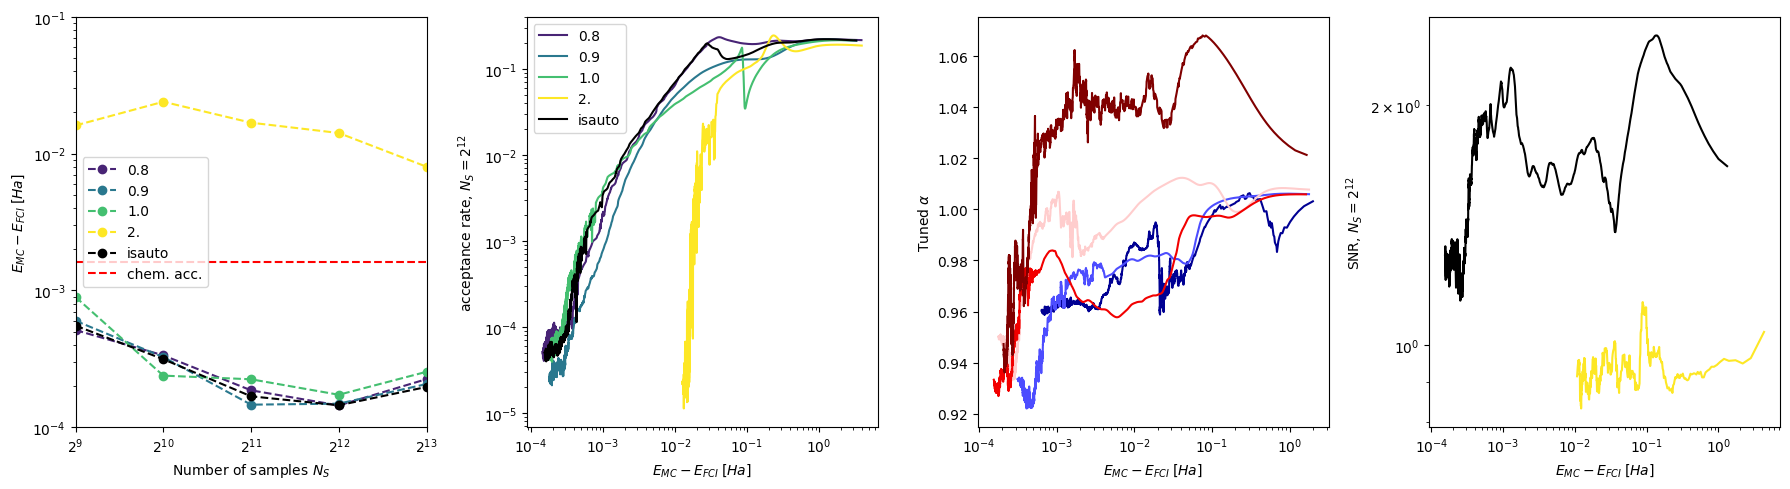

In [22]:
fig, axes = plt.subplots(1,4,figsize=(18,5))
for idx, is_key in enumerate(is_keys):
    if is_key=='isauto':
        color='black'
    else:
        color=cmap_key[idx]
    axes[0].plot(2**np.array(samples), out_dict[is_key], linestyle = '--', marker='o', label=is_key, color=color)
        # plt.fill_between(2**np.array(samples), np.array(min_l) + np.sqrt(np.array(var_l)/2**13), np.array(min_l) - np.sqrt(np.array(var_l)/2**13), alpha=0.5)

for idx, is_key in enumerate(is_keys):
    if out_dict[f"12_{is_key}_rel_err"].ndim > 1:
        energy = np.mean(out_dict[f"12_{is_key}_rel_err"], axis=0)
        acceptance = np.mean(out_dict[f"12_{is_key}_acceptance"], axis=0)
    a,b = sort_by_first(energy, acceptance)
    if is_key=='isauto':
        color='black'
    else:
        color=cmap_key[idx]
    axes[1].plot(moving_average(a,5),moving_average(b,5),color=color, label=is_key)


for idx, sample in enumerate(samples):
    e_vals, alpha_vals = out_dict[f'{sample}_rel_err'], out_dict[f'{sample}_alpha_opt']
    e_vals = np.mean(e_vals, axis=0)
    alpha_vals = np.mean(alpha_vals, axis=0)
    a, b = sort_by_first(e_vals, alpha_vals)
    axes[2].plot(moving_average(a, 15),moving_average(b,15), color=colors[idx], label=r'$N_S=2^{%s}$'%sample)

with open('/mnt/beegfs/home/CPHT/antoine.misery/workdir_link/qchem_comp_4/166630_0/L30/NNBF/256/MC_12_2.0/schedule_schedule/run_2.log') as f:
    log_data = json.load(f)
    snr_vals, energy_vals = remove_nan_pairs(np.array(log_data['info']['snr']['value']), np.array(log_data["Energy"]['Mean']["real"]))
    rel_err = np.abs(energy_vals + 87.892693)
    out_dict['12_2._snr'] = snr_vals
    out_dict['12_2._rel_err_snr'] = rel_err
    a, b = sort_by_first(rel_err, snr_vals)
    axes[3].plot(moving_average(a,20), np.sqrt(2**12)*moving_average(b,20), color=cmap_key[-1])
energy = np.mean(out_dict[f"12_isauto_rel_err"], axis=0)
snr = np.mean(out_dict[f"12_snr"], axis=0)
a,b = sort_by_first(energy, snr)
axes[3].plot(moving_average(a,20), np.sqrt(2**12)*moving_average(b,20), color='black')
axes[3].set_yscale('log')
axes[3].set_xscale('log')


axes[1].set_xlabel('')
axes[0].set_xscale('log', base=2)
axes[0].set_yscale('log')
for i in range(1,3):
    axes[i].set_xscale('log')
axes[1].set_yscale('log')

axes[0].set_xlabel(r'Number of samples $N_S$')
axes[0].set_ylabel(r'$E_{MC} - E_{FCI} \; [Ha]$')

axes[1].set_xlabel(r'$E_{MC} - E_{FCI}\; [Ha]$')
axes[1].set_ylabel(r'acceptance rate, $N_S=2^{12}$')

axes[2].set_xlabel(r'$E_{MC} - E_{FCI}\; [Ha]$')
axes[2].set_ylabel(r'Tuned $\alpha$')

axes[3].set_xlabel(r'$E_{MC} - E_{FCI}\; [Ha]$')
axes[3].set_ylabel(r'SNR, $N_S=2^{12}$')
axes[0].hlines(1.6e-3, 2**9, 2**13, color='red', linestyles='--', label='chem. acc.')
axes[0].set_xlim(2**9, 2**13)
axes[0].set_ylim(1e-4, 1e-1)
axes[0].legend()
axes[1].legend()
fig.tight_layout()

In [24]:
np.savez('relerr66_Li2O_0.npz', **out_dict)

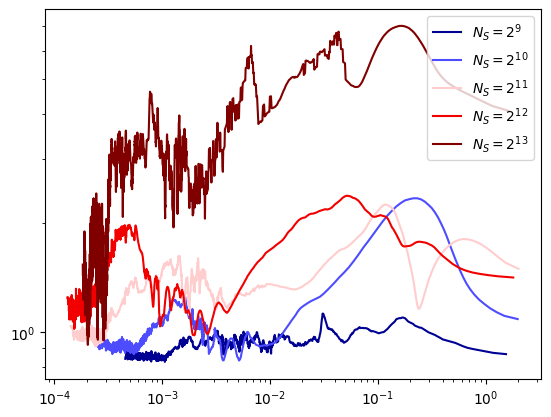

In [7]:
for idx, sample in enumerate(samples):
    e_vals, alpha_vals = alpha_dict[sample] 
    snr_vals = out_dict[f"{sample}_snr"]
    a, b = sort_by_first(e_vals, snr_vals)
    plt.plot(moving_average(a, 15), np.sqrt(2**sample) * moving_average(b,15), label=r'$N_S = 2^{%s}$'%sample, color=colors[idx])
plt.xscale('log')
plt.yscale('log')
plt.legend()

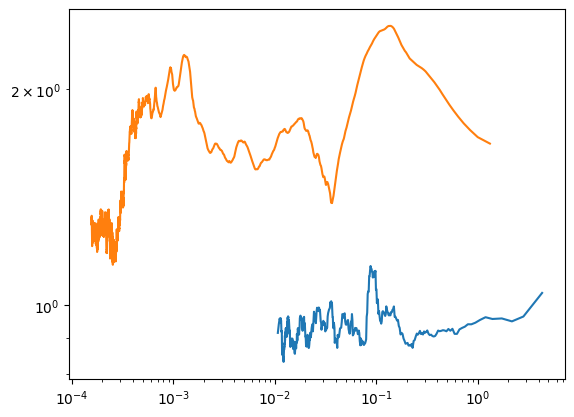

In [43]:
with open('/mnt/beegfs/home/CPHT/antoine.misery/workdir_link/qchem_comp_4/166630_0/L30/NNBF/256/MC_12_2.0/schedule_schedule/run_2.log') as f:
    log_data = json.load(f)
    snr_vals, energy_vals = remove_nan_pairs(np.array(log_data['info']['snr']['value']), np.array(log_data["Energy"]['Mean']["real"]))
    rel_err = np.abs(energy_vals + 87.892693)
    a, b = sort_by_first(rel_err, snr_vals)
    plt.plot(moving_average(a,20), np.sqrt(2**12)*moving_average(b,20))
energy = np.mean(out_dict[f"12_isauto_rel_err"], axis=0)
snr = np.mean(out_dict[f"12_snr"], axis=0)
a,b = sort_by_first(energy, snr)
plt.plot(moving_average(a,20), np.sqrt(2**12)*moving_average(b,20))
plt.yscale('log')
plt.xscale('log')
                        

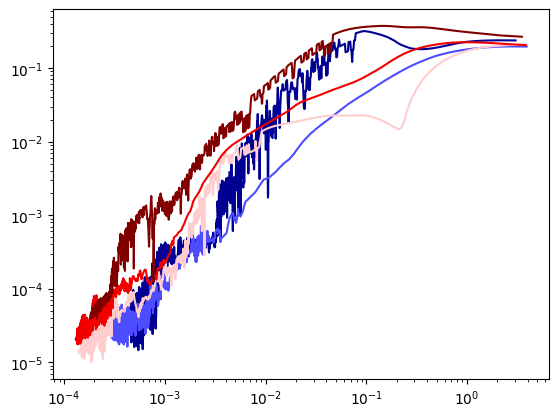

In [9]:
cmap_key = viridis(np.linspace(0.1, 1, len(is_keys)-1))
for idx, sample in enumerate(samples):
    energy = out_dict[f"{sample}_isauto_rel_err"]
    acceptance = out_dict[f"{sample}_isauto_acceptance"]
    a,b = sort_by_first(energy, acceptance)
    if is_key == 'isauto':
        color = 'black'
    plt.plot(moving_average(a,5),moving_average(b,5), color=colors[idx])
plt.xscale('log')
plt.yscale('log')